In [1]:
# ===================================
# BLOQUE 1: IMPORTACIÓN DE LIBRERÍAS
# ===================================

# Librerías básicas
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Transformers (para ViT)
from transformers import ViTForImageClassification, ViTModel

# PIL para imágenes
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost
import xgboost as xgb

# tqdm para barras de progreso
from tqdm import tqdm
import time

# Configurar semillas para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Usando dispositivo: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


✅ Usando dispositivo: cuda
✅ GPU: NVIDIA RTX 6000 Ada Generation
✅ Memoria disponible: 51.53 GB


In [2]:
# ========================================
# BLOQUE 2: CARGA DEL DATASET
# ========================================

from collections import defaultdict

class FruitDataset(Dataset):
    """Dataset personalizado para cargar frutas con estructura jerárquica"""
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        # Verificar que el directorio existe
        if not self.root_dir.exists():
            raise ValueError(f"El directorio {self.root_dir} no existe")
        
        # Obtener todas las combinaciones fruta-estado como clases
        classes = []
        fruit_folders = sorted([d for d in self.root_dir.iterdir() 
                               if d.is_dir() and d.name != 'desktop.ini'])
        
        for fruit_folder in fruit_folders:
            state_folders = sorted([d for d in fruit_folder.iterdir() 
                                   if d.is_dir()])
            for state_folder in state_folders:
                class_name = f"{fruit_folder.name}_{state_folder.name}"
                classes.append((class_name, state_folder))
        
        # Crear mapeo de clases
        classes = sorted(classes, key=lambda x: x[0])
        self.class_to_idx = {cls[0]: idx for idx, cls in enumerate(classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        print(f"{'='*60}")
        print(f"ESTRUCTURA DEL DATASET")
        print(f"{'='*60}")
        
        # Cargar todas las imágenes
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        
        for class_name, class_path in classes:
            class_idx = self.class_to_idx[class_name]
            
            image_files = [f for f in class_path.iterdir() 
                          if f.is_file() and f.suffix.lower() in valid_extensions]
            
            for img_path in image_files:
                self.images.append(str(img_path))
                self.labels.append(class_idx)
            
            print(f"  {class_name:30} -> {len(image_files):4} imágenes")
        
        if len(self.images) == 0:
            raise ValueError("No se encontraron imágenes en ninguna subcarpeta")
        
        print(f"{'='*60}")
        print(f"Total de imágenes: {len(self.images)}")
        print(f"Número de clases: {len(self.class_to_idx)}")
        print(f"{'='*60}\n")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error al cargar imagen {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Cargar dataset SIN transformaciones
dataset_path = r"C:\Users\I21309\Documents\examen_ultimo\frutas"
full_dataset = FruitDataset(dataset_path, transform=None)

# Dividir en train/val/test (70/15/15) con estratificación
train_idx, temp_idx = train_test_split(
    range(len(full_dataset)), 
    test_size=0.3, 
    random_state=42,
    stratify=full_dataset.labels
)

val_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.5, 
    random_state=42,
    stratify=[full_dataset.labels[i] for i in temp_idx]
)

print(f"{'='*60}")
print(f"DIVISIÓN DEL DATASET")
print(f"{'='*60}")
print(f"Train:      {len(train_idx):5} imágenes ({len(train_idx)/len(full_dataset)*100:.1f}%)")
print(f"Validation: {len(val_idx):5} imágenes ({len(val_idx)/len(full_dataset)*100:.1f}%)")
print(f"Test:       {len(test_idx):5} imágenes ({len(test_idx)/len(full_dataset)*100:.1f}%)")
print(f"{'='*60}\n")

ESTRUCTURA DEL DATASET
  Apple_Formalin-mixed           ->  643 imágenes
  Apple_Fresh                    ->  765 imágenes
  Apple_Rotten                   ->  630 imágenes
  Banana_Formalin-mixed          ->  660 imágenes
  Banana_Fresh                   ->  749 imágenes
  Banana_Rotten                  ->  632 imágenes
  Grape_Formalin-mixed           ->  610 imágenes
  Grape_Fresh                    ->  770 imágenes
  Grape_Rotten                   ->  630 imágenes
  Mango_Formalin-mixed           ->  616 imágenes
  Mango_Fresh                    ->  763 imágenes
  Mango_Rotten                   ->  630 imágenes
  Orange_Formalin-mixed          ->  647 imágenes
  Orange_Fresh                   ->  753 imágenes
  Orange_Rotten                  ->  656 imágenes
Total de imágenes: 10154
Número de clases: 15

DIVISIÓN DEL DATASET
Train:       7107 imágenes (70.0%)
Validation:  1523 imágenes (15.0%)
Test:        1524 imágenes (15.0%)




VISUALIZANDO 6 MUESTRAS ALEATORIAS DE CADA CLASE


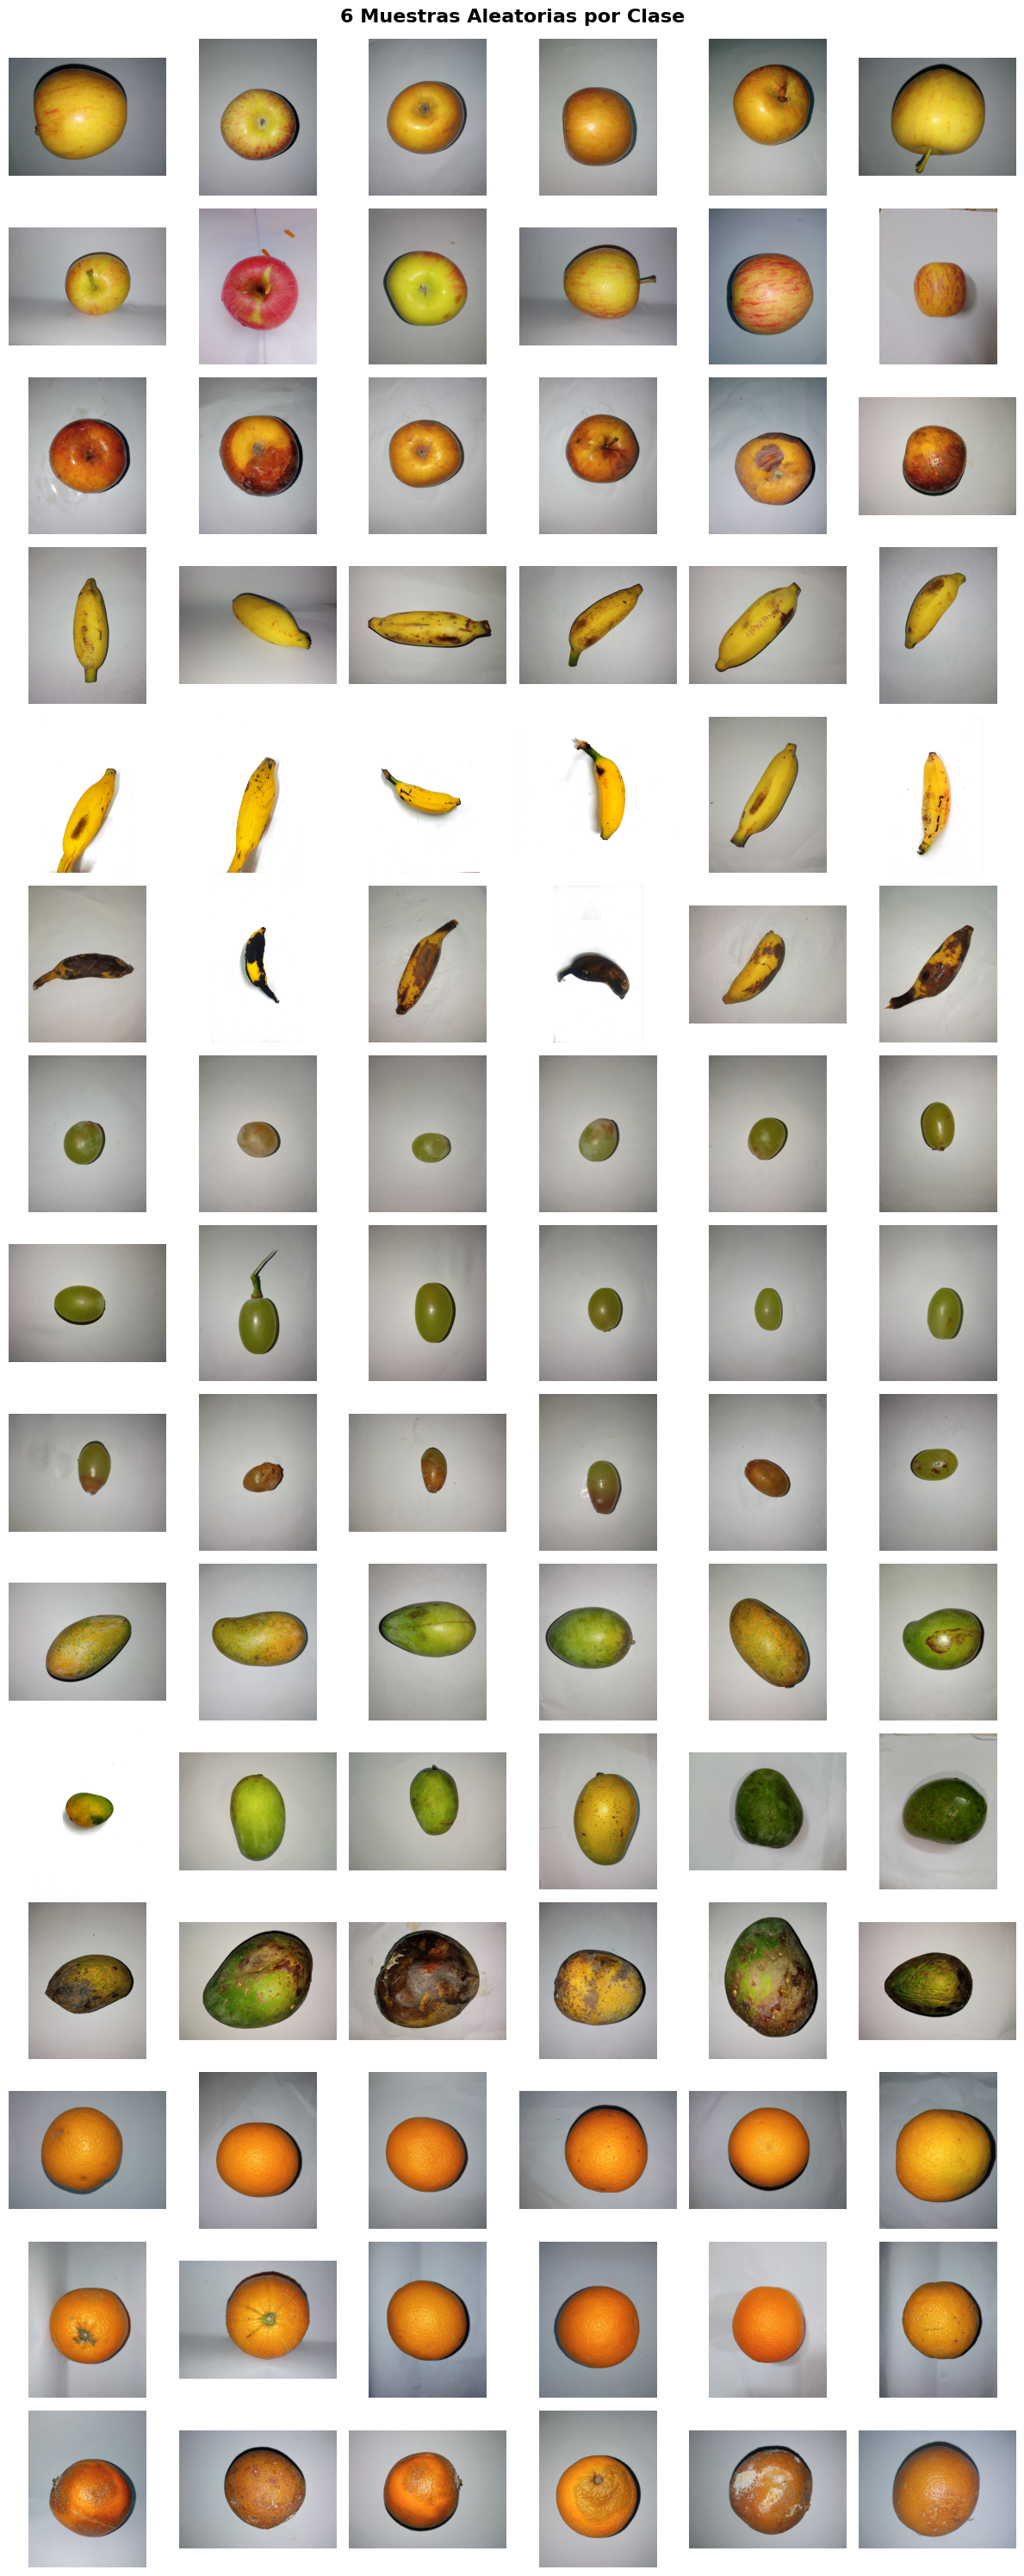


DISTRIBUCIÓN DE IMÁGENES POR CLASE


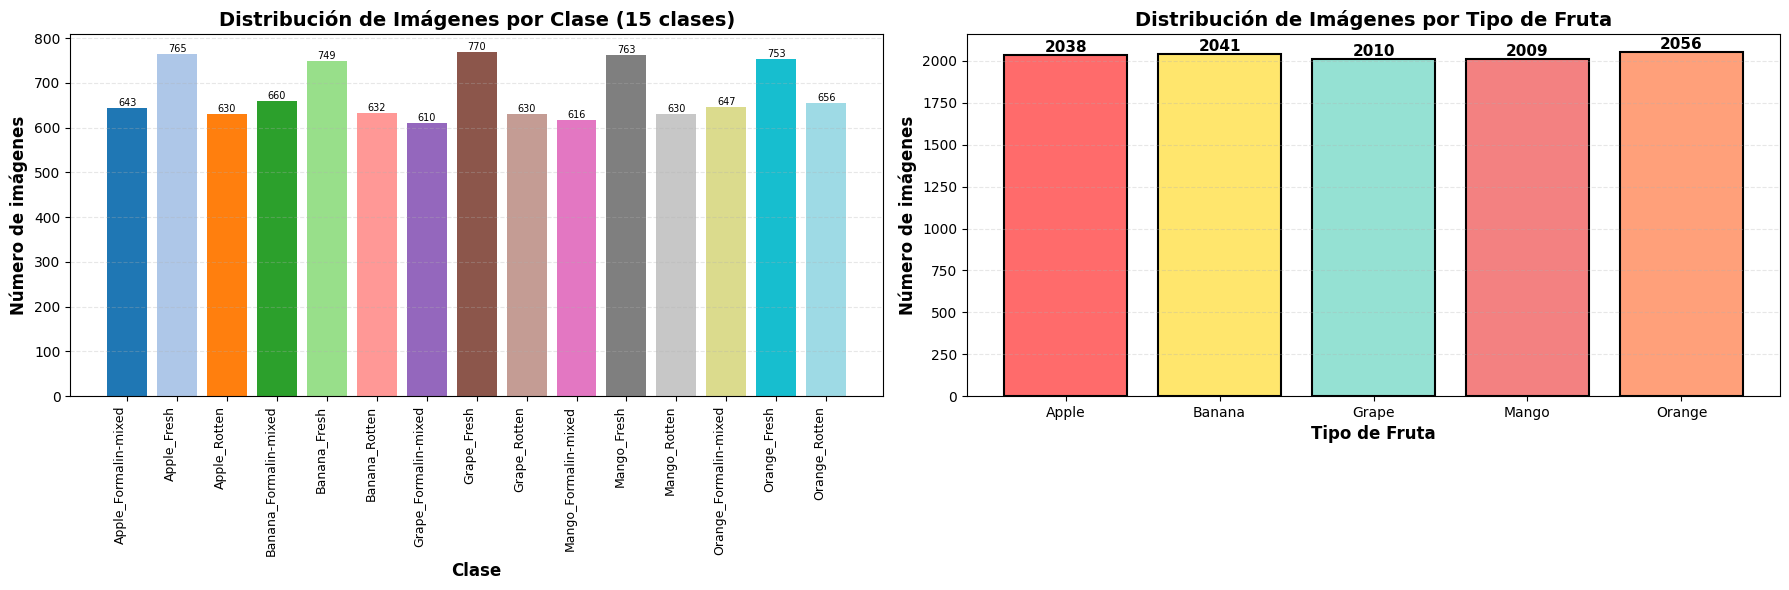


RESUMEN DE DISTRIBUCIÓN

Por tipo de fruta:
  Apple           ->  2038 imágenes
  Banana          ->  2041 imágenes
  Grape           ->  2010 imágenes
  Mango           ->  2009 imágenes
  Orange          ->  2056 imágenes

Por clase completa:
  Clase  0 - Apple_Formalin-mixed           ->  643 imágenes
  Clase  1 - Apple_Fresh                    ->  765 imágenes
  Clase  2 - Apple_Rotten                   ->  630 imágenes
  Clase  3 - Banana_Formalin-mixed          ->  660 imágenes
  Clase  4 - Banana_Fresh                   ->  749 imágenes
  Clase  5 - Banana_Rotten                  ->  632 imágenes
  Clase  6 - Grape_Formalin-mixed           ->  610 imágenes
  Clase  7 - Grape_Fresh                    ->  770 imágenes
  Clase  8 - Grape_Rotten                   ->  630 imágenes
  Clase  9 - Mango_Formalin-mixed           ->  616 imágenes
  Clase 10 - Mango_Fresh                    ->  763 imágenes
  Clase 11 - Mango_Rotten                   ->  630 imágenes
  Clase 12 - Orange_Fo

In [3]:
# ========================================
# BLOQUE 3: VISUALIZACIÓN DEL DATASET
# ========================================

def visualize_random_samples_per_class(dataset, num_samples=6):
    """
    Visualiza 6 muestras aleatorias de TODAS las clases
    """
    # Agrupar imágenes por clase
    class_images = defaultdict(list)
    for idx in range(len(dataset)):
        label = dataset.labels[idx]
        class_images[label].append(idx)
    
    num_classes = len(class_images)
    
    # Crear grid: 15 clases x 6 muestras
    fig, axes = plt.subplots(num_classes, num_samples, 
                            figsize=(num_samples*2, num_classes*2))
    
    for class_idx in sorted(class_images.keys()):
        class_name = dataset.idx_to_class[class_idx]
        indices = class_images[class_idx]
        
        # Seleccionar 6 muestras aleatorias
        selected_indices = random.sample(indices, min(num_samples, len(indices)))
        
        for col in range(num_samples):
            ax = axes[class_idx, col]
            
            if col < len(selected_indices):
                img_idx = selected_indices[col]
                img, label = dataset[img_idx]
                
                # Mostrar imagen tal cual
                ax.imshow(img)
                ax.axis('off')
                
                # Título solo en la primera columna
                if col == 0:
                    ax.set_ylabel(f"{class_name}\n(Clase {class_idx})", 
                                fontsize=8, fontweight='bold', rotation=0, 
                                labelpad=80, ha='right', va='center')
            else:
                ax.axis('off')
    
    plt.suptitle('6 Muestras Aleatorias por Clase', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('muestras_aleatorias_por_clase.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_class_distribution(dataset):
    """
    Grafica la distribución de imágenes por clase
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # ========================================
    # Gráfico 1: Distribución por las 15 clases
    # ========================================
    class_counts = pd.Series(dataset.labels).value_counts().sort_index()
    class_names = [dataset.idx_to_class[i] for i in class_counts.index]
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))
    bars = ax1.bar(range(len(class_names)), class_counts.values, color=colors)
    ax1.set_xticks(range(len(class_names)))
    ax1.set_xticklabels(class_names, rotation=90, ha='right', fontsize=9)
    ax1.set_xlabel('Clase', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Número de imágenes', fontsize=12, fontweight='bold')
    ax1.set_title('Distribución de Imágenes por Clase (15 clases)', 
                 fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Añadir valores encima de las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=7)
    
    # ========================================
    # Gráfico 2: Distribución por tipo de fruta (5 frutas)
    # ========================================
    fruit_counts = defaultdict(int)
    for label in dataset.labels:
        fruit = dataset.idx_to_class[label].split('_')[0]
        fruit_counts[fruit] += 1
    
    fruits = sorted(fruit_counts.keys())
    counts = [fruit_counts[f] for f in fruits]
    
    colors_fruit = ['#FF6B6B', '#FFE66D', '#95E1D3', '#F38181', '#FFA07A']
    bars2 = ax2.bar(fruits, counts, color=colors_fruit, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Tipo de Fruta', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Número de imágenes', fontsize=12, fontweight='bold')
    ax2.set_title('Distribución de Imágenes por Tipo de Fruta', 
                 fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Añadir valores encima de las barras
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('distribucion_clases.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ========================================
    # Tabla resumen
    # ========================================
    print(f"\n{'='*60}")
    print(f"RESUMEN DE DISTRIBUCIÓN")
    print(f"{'='*60}")
    print(f"\nPor tipo de fruta:")
    for fruit in fruits:
        print(f"  {fruit:15} -> {fruit_counts[fruit]:5} imágenes")
    
    print(f"\nPor clase completa:")
    for i, class_name in enumerate(class_names):
        print(f"  Clase {i:2} - {class_name:30} -> {class_counts.values[i]:4} imágenes")
    print(f"{'='*60}\n")


# ========================================
# EJECUTAR VISUALIZACIONES
# ========================================

print("\n" + "="*60)
print("VISUALIZANDO 6 MUESTRAS ALEATORIAS DE CADA CLASE")
print("="*60)
visualize_random_samples_per_class(full_dataset, num_samples=6)

print("\n" + "="*60)
print("DISTRIBUCIÓN DE IMÁGENES POR CLASE")
print("="*60)
plot_class_distribution(full_dataset)

In [ ]:
# ========================================
# BLOQUE 4: DATALOADERS, TRANSFORMACIONES Y ENTRENAMIENTO SWIN TRANSFORMER
# ========================================

from transformers import AutoImageProcessor, SwinForImageClassification

# ========================================
# 4.1: DEFINIR TRANSFORMACIONES
# ========================================

print(f"\n{'='*60}")
print("DEFINIENDO TRANSFORMACIONES")
print(f"{'='*60}\n")

# Transformaciones para ENTRENAMIENTO (con data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Transformaciones para VALIDACIÓN y TEST (solo resize y normalización)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

print("✅ Transformaciones de entrenamiento: Resize, RandomCrop, Flip, Rotation, ColorJitter")
print("✅ Transformaciones de val/test: Resize, Normalize")

# ========================================
# 4.2: CREAR DATASETS CON TRANSFORMACIONES
# ========================================

print(f"\n{'='*60}")
print("CREANDO DATASETS CON TRANSFORMACIONES")
print(f"{'='*60}\n")

# Crear datasets separados con sus transformaciones
train_dataset = FruitDataset(dataset_path, transform=train_transform)
val_dataset = FruitDataset(dataset_path, transform=val_test_transform)
test_dataset = FruitDataset(dataset_path, transform=val_test_transform)

# Crear subsets usando los índices ya divididos
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)
test_subset = Subset(test_dataset, test_idx)

print(f"Train subset: {len(train_subset)} imágenes")
print(f"Val subset:   {len(val_subset)} imágenes")
print(f"Test subset:  {len(test_subset)} imágenes")

# ========================================
# 4.3: CREAR DATALOADERS
# ========================================

print(f"\n{'='*60}")
print("CREANDO DATALOADERS")
print(f"{'='*60}\n")

BATCH_SIZE = 32


train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
     
    pin_memory=True
)

test_loader = DataLoader(
    test_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
     
    pin_memory=True
)

print(f"Train loader: {len(train_loader)} batches de {BATCH_SIZE} imágenes")
print(f"Val loader:   {len(val_loader)} batches de {BATCH_SIZE} imágenes")
print(f"Test loader:  {len(test_loader)} batches de {BATCH_SIZE} imágenes")

# ========================================
# 4.4: DEFINIR MODELO SWIN TRANSFORMER
# ========================================

print(f"\n{'='*60}")
print("CARGANDO MODELO SWIN TRANSFORMER")
print(f"{'='*60}\n")

# Cargar modelo preentrenado Swin Transformer
NUM_CLASSES = 15

model_swin = SwinForImageClassification.from_pretrained(
    'microsoft/swin-tiny-patch4-window7-224',
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

model_swin = model_swin.to(device)

print(f"✅ Modelo Swin Transformer cargado: microsoft/swin-tiny-patch4-window7-224")
print(f"✅ Número de clases: {NUM_CLASSES}")
print(f"✅ Dispositivo: {device}")

# Contar parámetros
total_params = sum(p.numel() for p in model_swin.parameters())
trainable_params = sum(p.numel() for p in model_swin.parameters() if p.requires_grad)

print(f"✅ Parámetros totales: {total_params:,}")
print(f"✅ Parámetros entrenables: {trainable_params:,}")

# ========================================
# 4.5: CONFIGURAR ENTRENAMIENTO
# ========================================

print(f"\n{'='*60}")
print("CONFIGURANDO ENTRENAMIENTO")
print(f"{'='*60}\n")

# Hiperparámetros
EPOCHS = 25
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.05

# Optimizador y scheduler
optimizer = AdamW(model_swin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

print(f"Épocas: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Optimizador: AdamW")
print(f"Scheduler: CosineAnnealingLR")
print(f"Loss: CrossEntropyLoss")

# ========================================
# 4.6: FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# ========================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Métricas
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Actualizar barra de progreso
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            
            # Métricas
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


# ========================================
# 4.7: ENTRENAMIENTO DEL MODELO
# ========================================

print(f"\n{'='*60}")
print("INICIANDO ENTRENAMIENTO CON SWIN TRANSFORMER")
print(f"{'='*60}\n")

# Historial de entrenamiento
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_state = None

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nÉpoca [{epoch+1}/{EPOCHS}]")
    print("-" * 60)
    
    # Entrenar
    train_loss, train_acc = train_epoch(model_swin, train_loader, criterion, optimizer, device)
    
    # Validar
    val_loss, val_acc = validate(model_swin, val_loader, criterion, device)
    
    # Actualizar scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Guardar mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model_swin.state_dict().copy()
        print(f"✅ Nuevo mejor modelo guardado (Val Acc: {val_acc:.2f}%)")
    
    # Imprimir resultados
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"LR: {current_lr:.6f}")

training_time = time.time() - start_time

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {training_time/60:.2f} minutos")
print(f"Mejor Val Acc: {best_val_acc:.2f}%")

# Cargar mejor modelo
model_swin.load_state_dict(best_model_state)

# ========================================
# 4.8: EVALUACIÓN EN TEST
# ========================================

print(f"\n{'='*60}")
print("EVALUACIÓN EN CONJUNTO DE TEST")
print(f"{'='*60}\n")

test_loss, test_acc = validate(model_swin, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.2f}%")

# ========================================
# 4.9: MATRIZ DE CONFUSIÓN Y MÉTRICAS DETALLADAS
# ========================================

print(f"\n{'='*60}")
print("GENERANDO MATRIZ DE CONFUSIÓN")
print(f"{'='*60}\n")

def get_predictions(model, loader, device):
    """Obtiene todas las predicciones del modelo"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Prediciendo'):
            images = images.to(device)
            outputs = model(images).logits
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Obtener predicciones
y_pred, y_true = get_predictions(model_swin, test_loader, device)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[full_dataset.idx_to_class[i] for i in range(NUM_CLASSES)],
            yticklabels=[full_dataset.idx_to_class[i] for i in range(NUM_CLASSES)],
            cbar_kws={'label': 'Número de muestras'})
plt.xlabel('Predicción', fontsize=12, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión - Swin Transformer', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('swin_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print("="*60)
class_names = [full_dataset.idx_to_class[i] for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names))

# ========================================
# 4.10: VISUALIZACIÓN DE CURVAS DE ENTRENAMIENTO
# ========================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Curva de Pérdida - Swin Transformer', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[1].axhline(y=test_acc, color='r', linestyle='--', linewidth=2, 
                label=f'Test Acc: {test_acc:.2f}%')
axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Curva de Precisión - Swin Transformer', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

# Learning Rate
axes[2].plot(history['lr'], marker='o', color='green', linewidth=2)
axes[2].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig('swin_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# ========================================
# 4.11: GUARDAR MODELO
# ========================================

torch.save({
    'model_state_dict': best_model_state,
    'history': history,
    'test_acc': test_acc,
    'test_loss': test_loss,
    'class_to_idx': full_dataset.class_to_idx,
    'idx_to_class': full_dataset.idx_to_class,
    'confusion_matrix': cm
}, 'swin_transformer_best_model.pth')

print(f"\n✅ Modelo Swin Transformer guardado como 'swin_transformer_best_model.pth'")
print(f"✅ Accuracy en Test: {test_acc:.2f}%")


DEFINIENDO TRANSFORMACIONES

✅ Transformaciones de entrenamiento: Resize, RandomCrop, Flip, Rotation, ColorJitter
✅ Transformaciones de val/test: Resize, Normalize

CREANDO DATASETS CON TRANSFORMACIONES

ESTRUCTURA DEL DATASET
  Apple_Formalin-mixed           ->  643 imágenes
  Apple_Fresh                    ->  765 imágenes
  Apple_Rotten                   ->  630 imágenes
  Banana_Formalin-mixed          ->  660 imágenes
  Banana_Fresh                   ->  749 imágenes
  Banana_Rotten                  ->  632 imágenes
  Grape_Formalin-mixed           ->  610 imágenes
  Grape_Fresh                    ->  770 imágenes
  Grape_Rotten                   ->  630 imágenes
  Mango_Formalin-mixed           ->  616 imágenes
  Mango_Fresh                    ->  763 imágenes
  Mango_Rotten                   ->  630 imágenes
  Orange_Formalin-mixed          ->  647 imágenes
  Orange_Fresh                   ->  753 imágenes
  Orange_Rotten                  ->  656 imágenes
Total de imágenes: 101

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modelo Swin Transformer cargado: microsoft/swin-tiny-patch4-window7-224
✅ Número de clases: 15
✅ Dispositivo: cuda
✅ Parámetros totales: 27,530,889
✅ Parámetros entrenables: 27,530,889

CONFIGURANDO ENTRENAMIENTO

Épocas: 25
Learning Rate: 0.0002
Weight Decay: 0.05
Optimizador: AdamW
Scheduler: CosineAnnealingLR
Loss: CrossEntropyLoss

INICIANDO ENTRENAMIENTO CON SWIN TRANSFORMER


Época [1/25]
------------------------------------------------------------


✅ Nuevo mejor modelo guardado (Val Acc: 78.46%)
Train Loss: 0.6580 | Train Acc: 73.44%
Val Loss:   0.5679 | Val Acc:   78.46%
LR: 0.000199

Época [2/25]
------------------------------------------------------------


Training:  98%|█████████▊| 218/222 [03:15<00:03,  1.14it/s, loss=0.1425, acc=87.16%]